## Import Google earth engine API and Authenticate

In [1]:
# import Google earth engine module
import ee

#Authenticate the Google earth engine with google account
# First firt setup only, no need to run this after first run


# ee.Authenticate()

# for normal/regular use for authorization
# this is required regularly
ee.Initialize()

## Import other package pandas, plotly, and Savitzky-Golay filter

In [30]:
#Pandas modules to interact data
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Define starting and ending year of study (Both year Inclusive)

In [44]:
# Longer the duration, Longer it will take for Processing and downloading of Images
StartDate = '2020-05-01'
EndDate = '2021-04-30'

## Define area of interest (Polygon) as feature collection

In [45]:
pol = ee.Geometry.Polygon(
    [[[81.03752257234235,28.560898024907527],
      [81.04466797715803,28.560898024907527],
      [81.04466797715803,28.56510070523194],
      [81.03752257234235,28.56510070523194],
      [81.03752257234235,28.560898024907527]
    ]])

In [46]:
ens = [
    ee.Feature(pol, {'name': 'nepal-crop-poly', 'id':1})
]

col =  ee.FeatureCollection(ens)
print(col.getInfo())

{'type': 'FeatureCollection', 'columns': {'id': 'Integer', 'name': 'String', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[81.03752257234235, 28.560898024907527], [81.04466797715803, 28.560898024907527], [81.04466797715803, 28.56510070523194], [81.03752257234235, 28.56510070523194], [81.03752257234235, 28.560898024907527]]]}, 'id': '0', 'properties': {'id': 1, 'name': 'nepal-crop-poly'}}]}


## Add date for each image 

In [47]:
def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('date').toInt())

## We are combining data from 2 sensors of MODIS (Terra And Aqua)

In [76]:
# add satellite time series: MODIS EVI 250m 16 day -------------
# terra sensor
collectionModEvi_terra = ee.ImageCollection('MODIS/006/MOD13Q1').filterDate(StartDate,EndDate) \
    .filterBounds(pol)\
    .select('NDVI')

# Aqua sensor
collectionModEvi_aqua = ee.ImageCollection('MODIS/061/MYD13Q1').filterDate(StartDate,EndDate) \
    .filterBounds(pol)\
    .select('NDVI');

collectionModEvi = collectionModEvi_terra.merge(collectionModEvi_aqua)
# THis will provide us 250 m of EVI datasets from MODIS on 8 day interval

## Extract Minimum, Mean & maximum NDVI values for each features based upon time series

In [77]:
def extractMinMaxMean(image):
    return image.reduceRegions(**{
    'collection':col,
    'reducer':ee.Reducer.minMax().combine(ee.Reducer.mean(), '', True), 
  })

In [79]:
ModNDVI = collectionModEvi.filterBounds(pol).map(addDate).map(extractMinMaxMean).flatten()

In [80]:
sample_result = ModNDVI.first().getInfo()
sample_result

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[81.03752257234235, 28.560898024907527],
    [81.04466797715803, 28.560898024907527],
    [81.04466797715803, 28.56510070523194],
    [81.03752257234235, 28.56510070523194],
    [81.03752257234235, 28.560898024907527]]]},
 'id': '1_2020_05_08_0',
 'properties': {'NDVI_max': 3737,
  'NDVI_mean': 3129.6121251629725,
  'NDVI_min': 2809,
  'date_max': 20200508,
  'date_mean': 20200508,
  'date_min': 20200508,
  'id': 1,
  'name': 'nepal-crop-poly'}}

In [81]:
# extract the properties column from feature collection
# column order may not be as our sample data order
column_df = ['NDVI_mean', 'NDVI_min', 'NDVI_max', 'date_min', 'id', 'name']

## Feature collection (mapped) to data frame with reducer 

In [83]:
nested_list = ModNDVI.reduceColumns(ee.Reducer.toList(len(column_df)), column_df).values().get(0)
data = nested_list.getInfo()
data

[[3129.6121251629725, 2809, 3737, 20200508, 1, 'nepal-crop-poly'],
 [2409.632985658409, 2227, 2808, 20200524, 1, 'nepal-crop-poly'],
 [2334.9915254237285, 2206, 3164, 20200609, 1, 'nepal-crop-poly'],
 [2166.88852672751, 834, 4272, 20200625, 1, 'nepal-crop-poly'],
 [8391.630378096479, 8253, 8544, 20200711, 1, 'nepal-crop-poly'],
 [6978.746414602348, 5374, 7964, 20200727, 1, 'nepal-crop-poly'],
 [8585.852672750978, 8531, 8743, 20200812, 1, 'nepal-crop-poly'],
 [8484.335071707954, 7906, 9217, 20200828, 1, 'nepal-crop-poly'],
 [7632.241199478487, 7466, 7949, 20200913, 1, 'nepal-crop-poly'],
 [4518.089960886571, 4333, 4735, 20200929, 1, 'nepal-crop-poly'],
 [3201.7359843546287, 3100, 3488, 20201015, 1, 'nepal-crop-poly'],
 [2950.6108213820085, 2797, 3365, 20201031, 1, 'nepal-crop-poly'],
 [2713.870925684485, 2138, 3618, 20201116, 1, 'nepal-crop-poly'],
 [4077.9582790091267, 3537, 5237, 20201202, 1, 'nepal-crop-poly'],
 [5710.940677966101, 5175, 6293, 20201218, 1, 'nepal-crop-poly'],
 [6339.

In [84]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(data, columns=column_df)
# we obtain the data frame as per our demand
# df

In [85]:
df['date']= pd.to_datetime(df['date_min'], format='%Y%m%d')
df_new = df.sort_values(by=['date'])
df_new


,NDVI_mean,NDVI_min,NDVI_max,date_min,id,name,date
0,3129.612125,2809,3737,20200508,1,nepal-crop-poly,2020-05-08
23,2635.853977,2489,3176,20200516,1,nepal-crop-poly,2020-05-16
1,2409.632986,2227,2808,20200524,1,nepal-crop-poly,2020-05-24
24,1866.889831,1123,2861,20200601,1,nepal-crop-poly,2020-06-01
2,2334.991525,2206,3164,20200609,1,nepal-crop-poly,2020-06-09
25,3095.935463,2875,3431,20200617,1,nepal-crop-poly,2020-06-17
3,2166.888527,834,4272,20200625,1,nepal-crop-poly,2020-06-25
26,6501.892438,4611,7113,20200703,1,nepal-crop-poly,2020-07-03
4,8391.630378,8253,8544,20200711,1,nepal-crop-poly,2020-07-11
27,6517.662321,4991,7426,20200719,1,nepal-crop-poly,2020-07-19


## Dataframe to charts visualizing the Minimum, Mean and Maximum values of NDVI values (timeseries Modis)

In [86]:
from scipy.signal import savgol_filter

In [87]:
import plotly.graph_objects as go
import matplotlib
import random

### Savitzky-Golay filter for regularization of NDVI values
Please adjust the values as per the datasets of you requirements

In [89]:
date = df_new['date'].tolist()
min = savgol_filter(df_new['NDVI_min'].tolist(), 9,2)
mean = savgol_filter(df_new['NDVI_mean'].tolist(), 9,2)
max = savgol_filter(df_new['NDVI_max'].tolist(),9,2)

#EE82EE


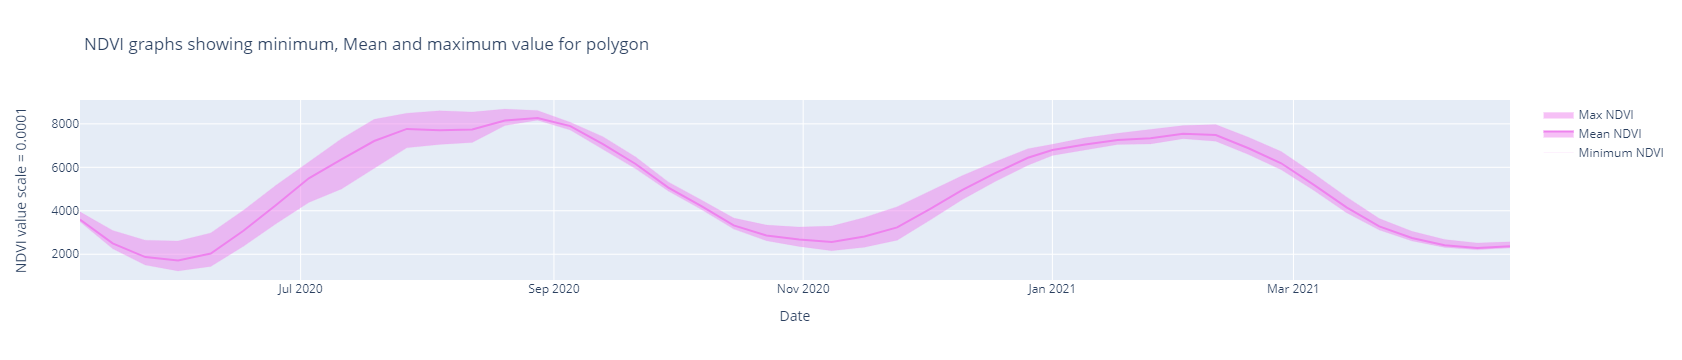

In [91]:
# reference taken from following link
# https://stackoverflow.com/a/61494764

#random color generation in plotly
hex_colors_dic = {}
rgb_colors_dic = {}
hex_colors_only = []
for name, hex in matplotlib.colors.cnames.items():
    hex_colors_only.append(hex)
    hex_colors_dic[name] = hex
    rgb_colors_dic[name] = matplotlib.colors.to_rgb(hex)


fig = go.Figure()
# c = random.choice(hex_colors_only)
c = '#EE82EE'
print(c)

# Create and style traces
fig.add_trace(go.Scatter(x=date, y=min, name='Minimum NDVI',
                         line=dict(color=c, width=0.1)))
fig.add_trace(go.Scatter(x=date, y=mean, name = 'Mean NDVI',
                         line=dict(color=c), fill='tonexty'))
fig.add_trace(go.Scatter(x=date, y=max, name='Max NDVI',
                         line=dict(color=c, width=0.1), fill='tonexty' # dash options include 'dash', 'dot', and 'dashdot'
))
# Edit the layout
fig.update_layout(title='NDVI graphs showing minimum, Mean and maximum value for polygon',
                   xaxis_title='Date',
                   yaxis_title='NDVI value scale = 0.0001')


fig.show()